# BEES1041 Exploring the Natural World #
# Week 2 Computer Exercise - Linear models and vegetation structure #
***
This week you will run R code to conduct some analyses of the tree measurement data you collected in Centennial Park. You will calculate some statistics and make some plots, and you will learn to define a linear model to describe the relationship between height and stem diameter at breast height (DBH). Then you will look at another dataset of tree measurements from the Ausplots Forests project, and compare that to the classes data. The exercise is a key component in three of the Course Learning Outcomes. It involves understanding experimental methods; processing, analysing, and interpreting data; and, communicating results in visual forms suitable for scientific reports.

***
## Linear regression ##
Linear regression is a very commonly used statistical technique among scientists who explore the natural world. It is used to model the relationship between a response (also called dependent) variable y and an explanatory (also called independent or predictor) variable x. For example, we could use linear regression to test whether temperature (the explanatory variable) is a good predictor of plant height (the response variable). We will use it to test how well DBH can predcit tree height.

In linear regression the model takes the form $y = \alpha + \beta{x} + \epsilon$
* $\alpha$ is the intercept (the value of y when x = 0)
* $\beta$ is the slope (amount of change in y for each unit of x
* $\epsilon$ is the error term.

The error term is the part that makes the model statistical rather than mathematical. The error term is drawn from a statistical distribution that captures the random variability in the response, and is assumed to be a normal (Gaussian) distribution. The goal in linear regression is to obtain the best estimates for the model coefficients ($\alpha$ and $\beta$). You should be aware that sometimes the model is written with different symbols for the coefficients (e.g., y = mx + b), and sometimes it is called called Ordinary Least Squares (OLS) linear regression. This is because the model finds the best values for the coeficients as those that minimise the sum of the squared difference between measured and modelled values. We will explore this concept during the notebook.

***
## Why do a regression? ##
Why would we want to predict tree height from DBH measurements?

One reason to predict height from DBH, is so you dont need to measure height during field work. It is pretty easy to measure DBH, as you discovered. Tree height is much more difficult to get accurate. This is often the point of modelling: to predict a measurement that is difficult to measure from one (or several) that is (or are) much easier to measure.

Another reason is that a linear regression model summarises the shape of the data into a line, described by its intercept and slope. This makes it easier to look at differences between two different datasets. For example, we can see if the relationship between DBH and height is different for trees measured by the class and those from mature forest sites measured by Ausplots Forests. 

***
## Part 1. The class data ##
First we will load the ggplot2 library that we will use for plotting, then we will load up the tree measurment data from the CSV file. We can print out the column names to remind ourselves how the data is organised, and print out the number of rows, to see how many trees were measured.

In [1]:
library(dplyr)
library(ggplot2)

tree_data <- read.csv('bees1041_tree_data_2023.csv')
colnames(tree_data)
nrow(tree_data)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] "Class"            "zID"              "Name"             "Latitude"        
 [5] "Longitude"        "Circumference_cm" "dbh_cm"           "Distance_m"      
 [9] "Angle"            "Eye_height_m"     "Tree_height_m"    "Tree_type"       
[13] "Notes"

[1] 474

We should do some checks on the data to make sure there aren't problems with the measurements. First, lets calculate DBH from the recorded circumference and check if it matches the recorded DBH.

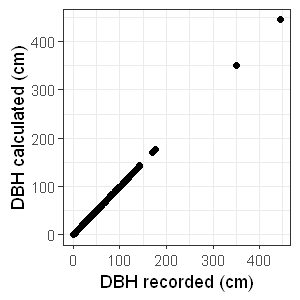

In [2]:
tree_data$dbh_calc <- tree_data$Circumference_cm / pi
options(repr.plot.width=2.5, repr.plot.height=2.5) # This defines the size of the plot in inches

ggplot(tree_data, aes(x = dbh_cm, y = dbh_calc)) +
       geom_point() +
       labs(x = "DBH recorded (cm)", y = "DBH calculated (cm)") +
       theme_bw()

We can see that all of the DBH values line up on the 1:1 line, which means that you all calculated diamater correctly. Well done!

Now lets check the height values. When we calculate the height we need to convert the angle from degrees to radians.

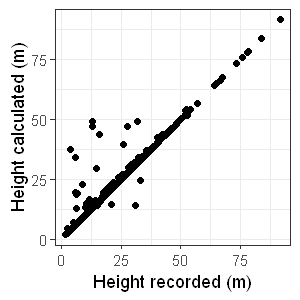

In [3]:
tree_data$Angle_radians <- tree_data$Angle * (pi/180)
tree_data$tree_height_calc <- tree_data$Eye_height_m + (tree_data$Distance_m * tan(tree_data$Angle_radians))
ggplot(tree_data, aes(x = Tree_height_m, y = tree_height_calc)) +
       geom_point() +
       labs(x = "Height recorded (m)", y = "Height calculated (m)") +
       theme_bw()

We can see that some of the height values do not match. Some of these might be from trees on a slope, or problems with the calculation. We can remove them from the dataset by using a threshold of 5 m on the difference between recorded and calculated values. Lets also print out how many trees we have after we have removed the problems.

[1] 457

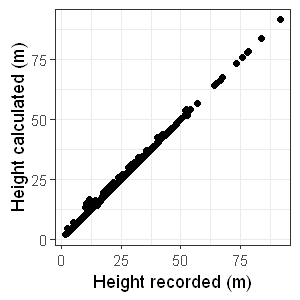

In [4]:
tree_data$height_error <- abs(tree_data$Tree_height_m - tree_data$tree_height_calc)
tree_data <- subset(tree_data, height_error < 5) # Use a treshold error of 5 m
ggplot(tree_data, aes(x = Tree_height_m, y = tree_height_calc)) +
       geom_point() +
       labs(x = "Height recorded (m)", y = "Height calculated (m)") +
       theme_bw()
nrow(tree_data)

Now we have checked the data and removed some problems, we can make a plot of DBH against height. In ggplot it is easy to colour the points by a category. Lets make a plot where we make trees in measured on different dates a different colour.

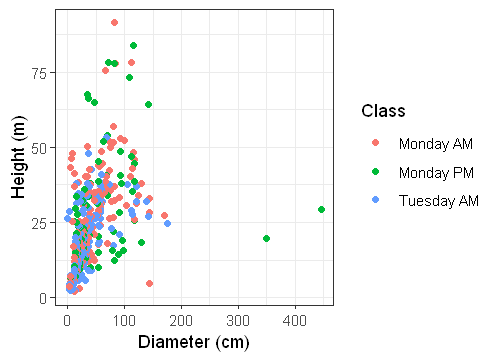

In [5]:
options(repr.plot.width=4.2, repr.plot.height=3)

ggplot(tree_data, aes(x = dbh_cm, y = Tree_height_m, colour = Class)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       theme_bw()

We can see three tree dots have much lower h for their measured diameter.

Lets make another plot, but this time we will colour by tree type, to see if that is causing those fat trees.

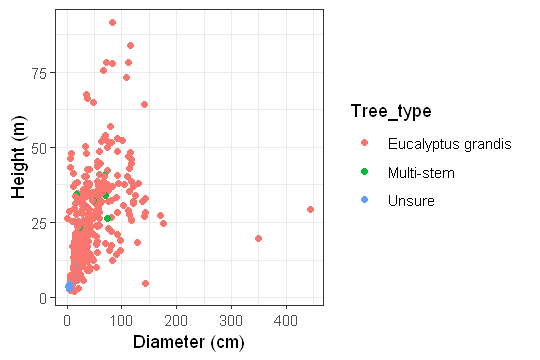

In [6]:
options(repr.plot.width=4.5, repr.plot.height=3)

ggplot(tree_data, aes(x = dbh_cm, y = Tree_height_m, colour = Tree_type)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       theme_bw()

So, it turns out that those three trees with larger DBH are not because the observer was unsure of the species.

Instead, we will try and use the multiple measurements to remove problem values. As the data contains repeat measurements of the same trees, we shouldn't treat them all as independant measurements. We should use the best value for each tree.

Firstly, how many different trees did we measure?

We can use the `n_distinct()` function from the `dplyr` package to find out.

In [7]:
n_distinct(tree_data$Name)

[1] 130

The code blow calculates the median DBH for each tree. The median is better than the mean for this sort of analysis, as it is less sensitive to extreme values. It then plots these median values (red crosses) alongside the original values (black dots). Values that are a long way from the median are probably incorrect.

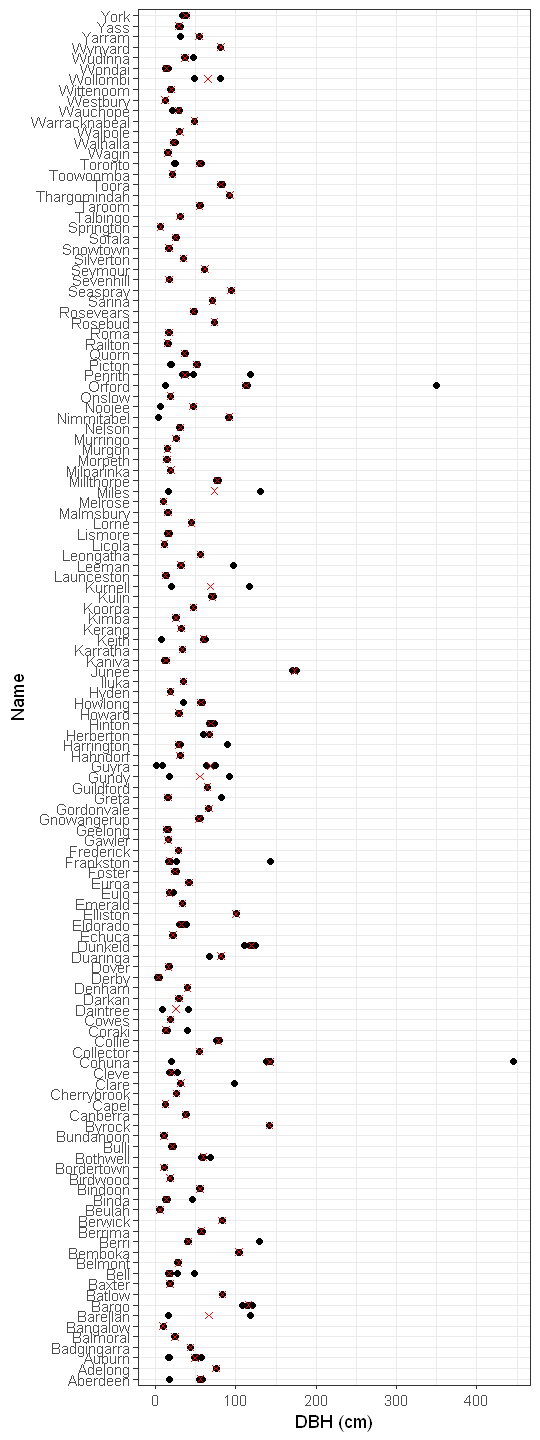

In [8]:
options(repr.plot.width=4.5, repr.plot.height=12)

trees_median_dbh <- aggregate(tree_data$dbh_cm, by = list(tree_data$Name), FUN = median)
colnames(trees_median_dbh) <- c("Name", "median_dbh_cm")

ggplot() +
    geom_point(data = tree_data, aes(x = dbh_cm, y = Name)) +
    geom_point(data = trees_median_dbh, aes(x = median_dbh_cm, y = Name), shape = 4, color='red') +
    labs(x = "DBH (cm)", y = "Name") +
    theme_bw()

There are a few values that are obviously incorrect. We can remnove these from the data by calculating the difference between the values and the median, and then taking a subset of the data. If we do this and then plot the data again, the outliers should be removed.

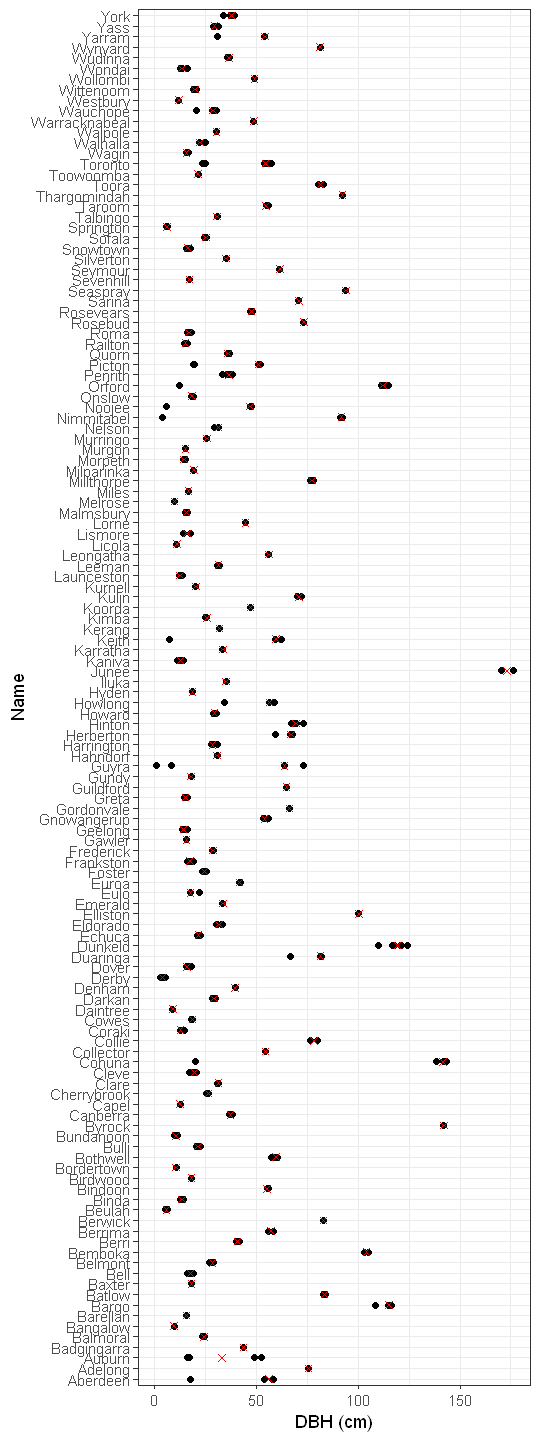

In [9]:
tree_data_merged <- merge(tree_data, trees_median_dbh, by = 'Name') # merge the median values into the original data

tree_data_merged$dbh_dif <- tree_data_merged$dbh_cm - tree_data_merged$median_dbh_cm # calculate the difference between the values and the medians

tree_data_subset <- subset(tree_data_merged, dbh_dif <= 5) # only keep data where the difference is less than 5 cm

# Calculate a new set of medians based on the subset data with outliers removed 
trees_median_dbh <- aggregate(tree_data_subset$dbh_cm, by = list(tree_data_subset$Name), FUN = median)
colnames(trees_median_dbh) <- c("Name", "Median_dbh_cm")

# Make the same plot as before
ggplot() +
    geom_point(data = tree_data_subset, aes(x = dbh_cm, y = Name)) +
    geom_point(data = trees_median_dbh, aes(x = Median_dbh_cm, y = Name), shape = 4, color='red') +
    labs(x = "DBH (cm)", y = "Name") +
    theme_bw()

Now all the DBH outliers have been removed, and the median values (red crosses) are close to real values.

Now lets see if there are outliers for the height measurements.

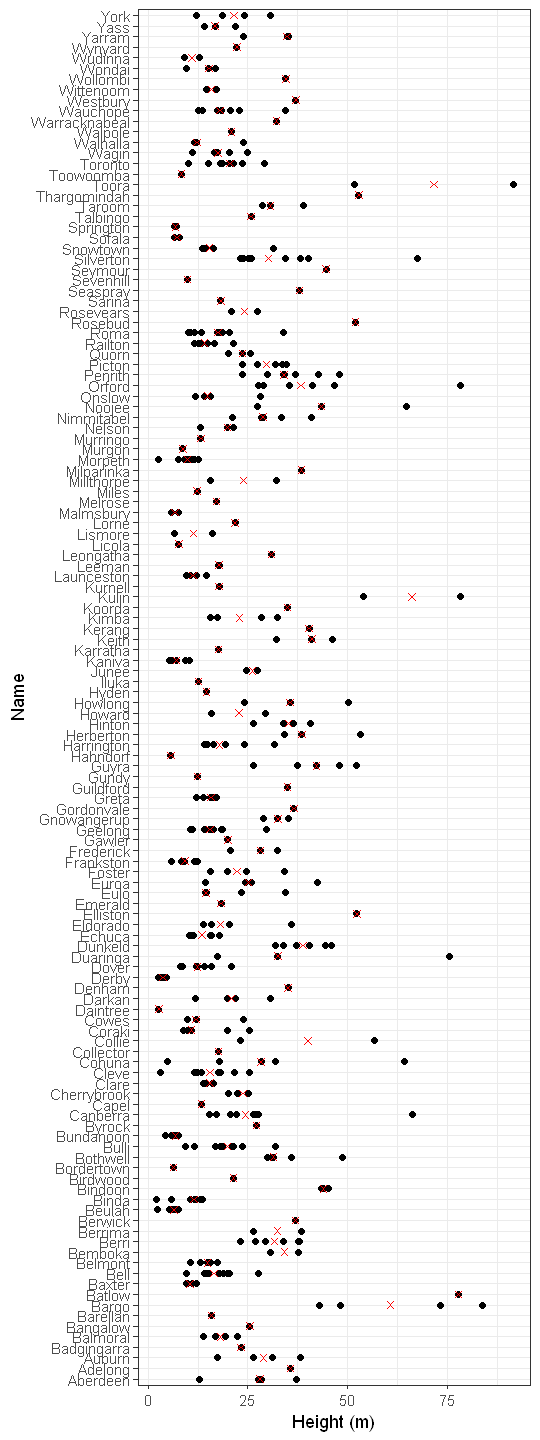

In [10]:
trees_median_height <- aggregate(tree_data_subset$Tree_height_m, by = list(tree_data_subset$Name), FUN = median)
colnames(trees_median_height) <- c("Name", "Median_tree_height_m")

ggplot() +
    geom_point(data = tree_data_subset, aes(x = Tree_height_m, y = Name)) +
    geom_point(data = trees_median_height, aes(x = Median_tree_height_m, y = Name), shape = 4, color='red') +
    labs(x = "Height (m)", y = "Name") +
    theme_bw()

Height is more variable than DBH, as it is more difficult to measure the angles to the treetops. This makes it harder to determine outliers. We will just have to assume that you were equally likely to overestimate and underestimate the angles, so the median value for height is a good approximation.

Lets create a dataframe with tree name, median DBH and median height and make a plot to see how DBH and height are related. 

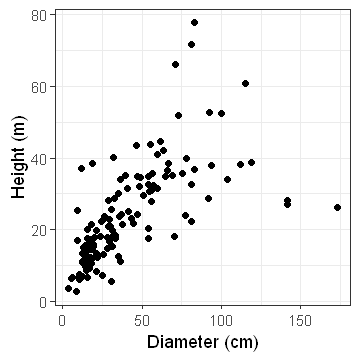

In [11]:
tree_data_median <- merge(trees_median_dbh, trees_median_height, by = 'Name')

options(repr.plot.width=3, repr.plot.height=3)

ggplot(tree_data_median, aes(x = Median_dbh_cm, y = Median_tree_height_m)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       theme_bw()

Now we will fit a linear regression between diameter and height using the `lm()` function, to see how closely the two variables are related, and to characterise the shape of this relationship. The main argument to `lm()` is the model formula y ~ x, where the response variable is on the left of the tilde (~) and the explanatory variable is on the right. The `summary()` function provides a deatiled output of the regression, including the values for the intercept and slope.

In [12]:
class_model <- lm(data = tree_data_median, Median_tree_height_m ~ Median_dbh_cm)
summary(class_model)


Call:
lm(formula = Median_tree_height_m ~ Median_dbh_cm, data = tree_data_median)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.060  -6.126  -1.368   4.018  41.513 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   12.23151    1.52994   7.995 6.64e-13 ***
Median_dbh_cm  0.28835    0.02943   9.797  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 10.55 on 128 degrees of freedom
Multiple R-squared:  0.4285,	Adjusted R-squared:  0.424 
F-statistic: 95.97 on 1 and 128 DF,  p-value: < 2.2e-16


The above summary gives lots of information, and can seem a bit overwhelming. I will explain the important parts that I want you to remember. The part that shows the intercept and slope is under the heading of Coefficients:

`Coefficients:`<br>
`              Estimate Std. Error t value Pr(>|t|)`<br>
`(Intercept)   12.56981    1.73801   7.232 6.26e-11 ***`<br>
`Median_dbh_cm  0.30786    0.03364   9.153 2.98e-15 ***`

In this case the intercept is 12.56981 and the slope is 0.30786, so the regression equation is:

<center>$height = 12.56981 + 0.30786DBH + \epsilon$

<br><br>
The strength of the modelled relationship is captured by the $R^2$ value, the proportion of variance in the response that is explained by the explanatory variable. The closer this is to 1.0, the better the model can explain the variance, or the better it can predict the response variable from the explanatory variable. In the model summary above the $R^2$ value is described as the `Multiple R-squared:  0.4279`. The reason it is called "multiple" $R^2$ is that you can use multiple predictor variables for the `lm()` function. The `Adjusted R-squared` value is better if you have multiple predictors, but in a single predictor case it is very similar.

To plot the regression line on the graph, we could use the `geom_smooth()` function in ggplot, which is like adding the trend line to an `Excel` plot. However, I prefer to do it a different way, which helps to illustrate what the regression line actually is. Firstly, I like to calculate the line position through applying the model to the measured DBH values, to create a set of height predictions. Then we can add a line to the graph that is defined by the measured DBH values and the predicted height values. Doing it this way emphasises that the vertical distance on the graph between the points and the line is the error in the model, or the difference between the measured and predicted values of height. These errors are also known as the residuals.

In the next cell, the first line of code creates a new predicted_height column in the data frame by applying the `predict()` function to the model that we made earlier. This is the same as if we applied the equation `tree_data_median$predicted_height <- 12.56981 + 0.30786*tree_data_median$Median_dbh_cm`
    
The second section of code makes the same graph we had before, but now it adds the regression line.

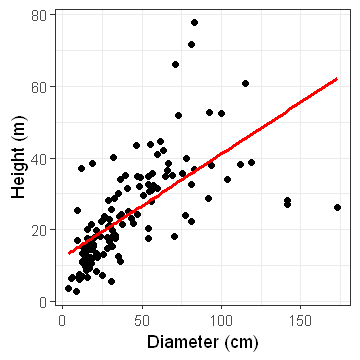

In [13]:
tree_data_median$predicted_height <- predict(class_model)

options(repr.plot.width=3, repr.plot.height=3)

ggplot(tree_data_median, aes(x = Median_dbh_cm, y = Median_tree_height_m)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       geom_line(aes(y = predicted_height), size = 1, color = 'red') +
       theme_bw()

One thing to check when fitting a linear regression, is whether our assumption of a linear relationship is true. There is no point trying to fit a straight line, if the relationship between the variables is curved. To test whether the linear assumption is true, we can look at a plot of the model residuals, which are the vertical differences between the predicted values (the line) and the measured values (the points). If there is no pattern in a plot of the residuals against the predicted values, then the assumption is true. We can make this residual plot by using the following simple code.

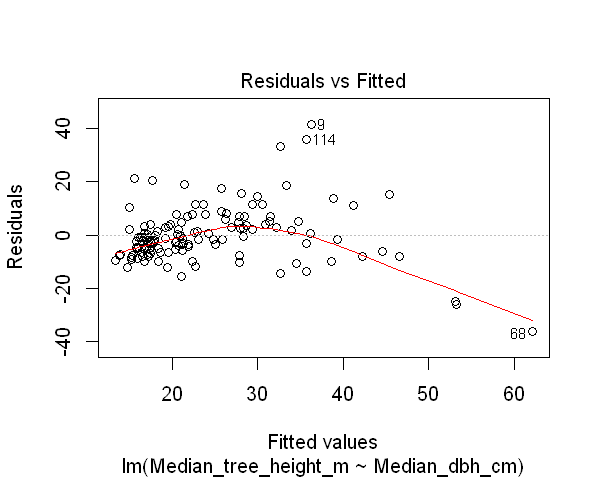

In [14]:
options(repr.plot.width=5, repr.plot.height=4)

plot(class_model, which = 1)

The isn't a strong pattern in the above graph, so our linear model appears appropriate for our data. There is a bit of a curve, but the top end is caused by only two data points.

If you want to look at graphs that clearly show patterns in the residuals, look at the "curved up" and "curved down" trends on this website: https://gallery.shinyapps.io/slr_diag/


***
## Part 2. Ausplots Forests data ##
Now we will look at the Ausplots Forests data. We will conduct an identical analysis to that on the class data, and we will see if the mature forest trees sampled have a different relationship between diameter and height than the class trees.

First we need to load the Ausplots Forests data from the CSV file, and check the column names, and the number of trees in the dataset.

In [15]:
ausplots_data <- read.csv('ausplot_forest_data.csv')
colnames(ausplots_data)
nrow(ausplots_data)

[1] "ID"                     "Ausplot_ID"             "Site_Name"             
 [4] "Date"                   "Subplot"                "Tree_ID"               
 [7] "Genus_Species"          "Tree_Condition"         "Tree_Status"           
[10] "Mode_Of_Death"          "Growth_Stage"           "Crown_Class"           
[13] "Diameter"               "Point_Of_Measurement"   "Diameter_2"            
[16] "Point_Of_Measurement_2" "Height"                 "Bole_Height"           
[19] "Height_Of_Break"        "Historic_ID"            "Comment"

[1] 24512

As we want the same types of trees that we used for the class data, we need to select all the *Eucalypt grandis* trees. But we also need to remove some trees whose data will be different. Looking at the column names, and opening the data in Excel, I can see out that we want to select only alive trees, where the diameter was measured at 1.3 m, and diameter and height were both measured. The `subset()` function will do this in the following cell.

In [16]:
ausplots_subset <- subset(ausplots_data,
                          (Genus_Species == 'Eucalyptus grandis') &
                          (Point_Of_Measurement == 1.3) &
                          (Diameter > 0) &
                          (Height > 0) &
                          (Tree_Status == 'A'))
nrow(ausplots_subset)

[1] 236

Now we only have far fewer trees than the original data, but we have made sure that we are comparing the same types of trees that we analysed in the class data.

The next code cell calculates the linear regression between DBH and height on the Ausplots Forests data, in the same way we did for the class data.

In [17]:
ausplot_model <- lm(Height ~ Diameter, data = ausplots_subset)
summary(ausplot_model)


Call:
lm(formula = Height ~ Diameter, data = ausplots_subset)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.379  -5.529  -0.751   5.189  27.140 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.53628    1.30725   13.41   <2e-16 ***
Diameter     0.42650    0.02568   16.61   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.691 on 234 degrees of freedom
Multiple R-squared:  0.5409,	Adjusted R-squared:  0.539 
F-statistic: 275.7 on 1 and 234 DF,  p-value: < 2.2e-16


Looking at the summary of the linear regression model, we can see that the intercept, slope and $R^2$ values are different to the model run on the class data.
* The $R^2$ is greater, as in this data DBH is explaining a greater proportion of the variance in tree height.
* The slope is greater, meaning that tree heights in Ausplots Forests increase quicker with DBH than our class data.
* The intercept is also greater, meaning that the model predicts that heights are greater when DBH is small in the Ausplots forests.

Now we should plot the data with the regression line and see the differences.

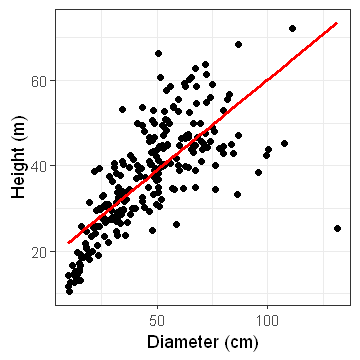

In [18]:
ausplots_subset$predicted_height <- predict(ausplot_model)

options(repr.plot.width=3, repr.plot.height=3)

ggplot(ausplots_subset, aes(x = Diameter, y = Height)) +
       geom_point() +
       labs(x = "Diameter (cm)", y = "Height (m)") +
       geom_line(aes(y = predicted_height), size = 1, color = 'red') +
       theme_bw()

One thing the plot shows, is that the linear model does not fit the data very well at each end of the scatter of points. For small DBH values most of the measured points are below the line. The same is true for large values of DBH.

We should look at a plot of the model residuals, to see if there is a pattern. We can make this residual plot by using the following simple code.

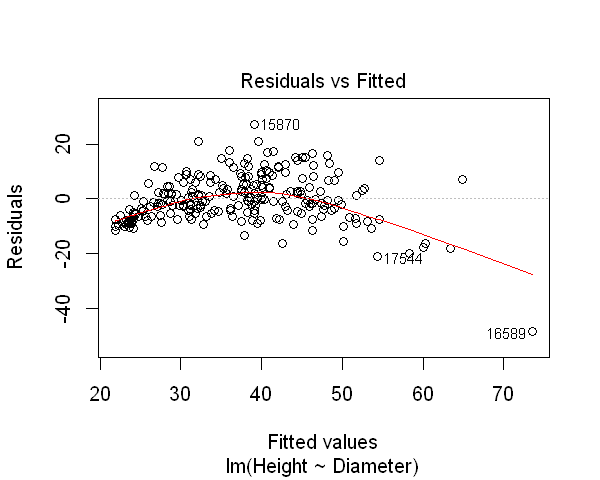

In [19]:
options(repr.plot.width=5, repr.plot.height=4)
plot(ausplot_model, which = 1)

The residual plot confirms that there is a pattern, and that the relationship between DBH an height is the Ausplots Forests data is not linear. We can look at fitting non-linear regression models in a future class. For now we will continue to look at the linear model, and how it is different to the class data.

It will be easier to see the two regression models if will create a plot with the class data and the Ausplots Forests data side by side. Use the `cowplot` library and the following code to make a figure with two panels. The `coord_cartesian()` function is used to make sure the axes of each graph have the same ranges.

Warning message:
"package 'cowplot' was built under R version 3.6.3"

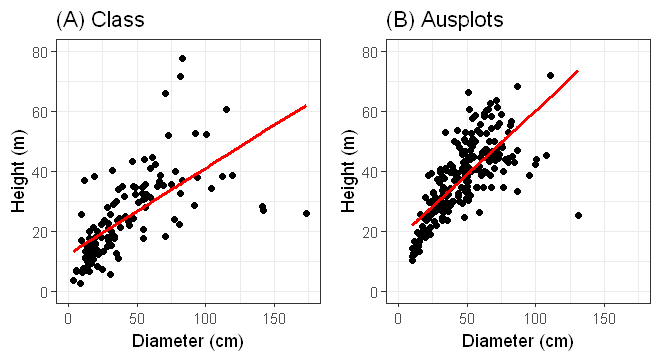

In [20]:
library(cowplot)
               
tree_plot <- ggplot(tree_data_median, aes(x = Median_dbh_cm, y = Median_tree_height_m)) +
                    geom_point() +
                    labs(x = "Diameter (cm)", y = "Height (m)", title = "(A) Class") +
                    geom_line(aes(y = predicted_height), size = 1, color = 'red') +
                    theme_bw() +
                    coord_cartesian(xlim=c(0, 175),
                                    ylim=c(0, 80))

aus_plot <- ggplot(ausplots_subset, aes(x = Diameter, y = Height)) +
                   geom_point() +
                   labs(x = "Diameter (cm)", y = "Height (m)", title = "(B) Ausplots") +
                   theme_bw() +
                   geom_line(aes(y = predicted_height), size = 1, color = 'red') +
                   coord_cartesian(xlim=c(0, 175),
                                   ylim=c(0, 80))

options(repr.plot.width=5.5, repr.plot.height=3)
plot_grid(tree_plot, aus_plot, ncol = 2, align = "h")

Now you should export the graphs you have created to image files. You can look at the code from last weeks computer exercise and add a code cell to save the graph.

In [21]:
# Add you code to export the graph here. This line is a comment, as it starts with a hash symbol.


# Comment lines do not affect the code at all.

This is the end of the exercise. You have explored two real datasets of measurements from the natural world, made some plots that can be saved and used in scientiic reports, and you have learned to define linear regression models and interpret their results.

***
# Final instructions #
There are a few things you need to do:
- Dont forget to answer the Moodle quiz questions for this lab.
- If you have any problems, or questions, please post on the Moodle forum.
- Save the completed notebook and download it to your computer, as SWAN scratch directories get emptied. Or you can move the files into your Cloustor directory. You can also download the graph.

***
# Further exercise #

The Ausplot Forests data set has lots of information that we havent explored. You can explore it further, to see if the spread of points on the DBH-height graph can be explained by some of the other variables recorded. For example, it would be interesting to see if certain Eucalypt tree species have linear models with greater $R^2$ values.